# Example Model Metamer Generation from VGG-19

This notebook walks through model metamer generation for an example image as a demonstration of the optimization used in the paper: 

*Metamers of neural networks reveal divergence from human perceptual systems. Feather, J., Durango, A., Gonzalez, R., & McDermott, J. (2019). In Advances in Neural Information Processing Systems.*

(Tested in tensorflow 1.13, with no guarantee to work with other versions)

# Download the model code, checkpoint, and null distribution

### Before running this notebook, you need to have the VGG-19 model code downloaded, and the trained checkpoint. 

Get an example network from the tfslim model repo, download full repo here: 
https://github.com/tensorflow/models/tree/master/research/slim

Specifically, we need the vgg.py model, located here: 
https://github.com/tensorflow/models/blob/master/research/slim/nets/vgg.py

The VGG-19 model is used in this demo. Download the checkpoint from here.  
http://download.tensorflow.org/models/vgg_19_2016_08_28.tar.gz

Untar the above file (`tar -xvf vgg_19_2016_08_28.tar.gz`) and you should have a file called `vgg_19.ckpt`.


### To compare the generated files to the null, you will also need the null distribution for VGG-19. 
The null for this model is downloadable from:
`http://mcdermottlab.mit.edu/jfeather/model_metamers/assets/vgg_null_dist_spearman_r.pckl`

# Now load the dependencies

In [1]:
import tensorflow as tf
import vgg
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from scipy.misc import imread, imresize
from imagenet_classes import class_names
import scipy
import sys
import os
import metamer_helpers
from lossfunctions import generate_loss_functions
import pickle



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Set up the input to the graph

Loading the network should include any preprocessing that was performed on the input (ie scale, shift, etc). 
Including the preprocessing in the metamer generation is important to ensure that generated metamers go through the same preprocessing that is applied to the natural input images. 

All of this is included in the `build_vgg_trained.py` script. When generating metamers for a new network, a separate build script should be written including the preprocessing.  

The build script also provides easy pointers to activation layers in the network, and applies the modified gradient ReLU to the desired layers. 


In [2]:
tf.reset_default_graph()

import build_vgg_trained as build_network
nets, sess, metamer_layers = build_network.main()

# Make a function that re-initializes the input variable
input_tensor, input_noise_assign_op = metamer_helpers.make_initialization_op_random_image(
    nets['input_image'], nets['max_image'], nets['min_image'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from vgg_19.ckpt
##### 
 UNINITIALIZED VARIABLES ARE:
[b'Variable']
#####
Loading: airplane.png


# Load an example image to generate metamers.

In [3]:
image_path = 'assets/pocketwatch.jpg'
image_dict = metamer_helpers.use_image_path_specified_image(image_path,
                                                            im_shape=224)

# Normalize between 0-1, since our variables are normalized to those values.
image_dict['image'] = (image_dict['image']-image_dict['min_value_image_set']) / (
                       image_dict['max_value_image_set']-image_dict['min_value_image_set'])

Loading: pocketwatch.jpg


# Set up a loss function. 

This is a partial function that we can apply to each of the metamer layers. For Feather et al. 2019 we use an L2 loss on the activations from single layers of the network. 

In [4]:
# The loss function used for metamer generation (L2 loss) is 'raw_pixels'
loss_function_name = 'raw_pixels' 
loss_function, measure_stats = generate_loss_functions(LOSS_TYPE=loss_function_name,
                                                       SHAPE_NORMALIZE=False)

# Run the optimization to generate metamers

Here we can run the optimization for each layer in `metamer_layers` and plot the example images. 

Note: This will take a long time to run in a notebook especially for the late layers of the network.
For this demonstration, we chose two example layers to optimize.   

Generating metamer for VGG layer conv1_2_jittered_relu
[0/15000], loss=37735337984.000000
[1000/15000], loss=269820896.000000
[2000/15000], loss=8311873.000000
[3000/15000], loss=2475667.750000
[4000/15000], loss=1160737.750000
[5000/15000], loss=630900.875000
[6000/15000], loss=364805.250000
[7000/15000], loss=214109.765625
[8000/15000], loss=124702.531250
[9000/15000], loss=71786.851562
[10000/15000], loss=41562.878906
[11000/15000], loss=24595.687500
[12000/15000], loss=15084.316406
[13000/15000], loss=8908.372070
[14000/15000], loss=5634.748535
[15000/15000], loss=3753.022705
Min orig: 0.000000 | Max orig : 0.988235
Min synth: 0.000000 | Max synth : 1.000000
Generating metamer for VGG layer conv5_4_jittered_relu
[0/15000], loss=3655203.000000
[1000/15000], loss=44429.710938
[2000/15000], loss=20542.750000
[3000/15000], loss=13242.463867
[4000/15000], loss=9387.541016
[5000/15000], loss=7159.362305
[6000/15000], loss=5656.408203
[7000/15000], loss=4596.280273
[8000/15000], loss=3902

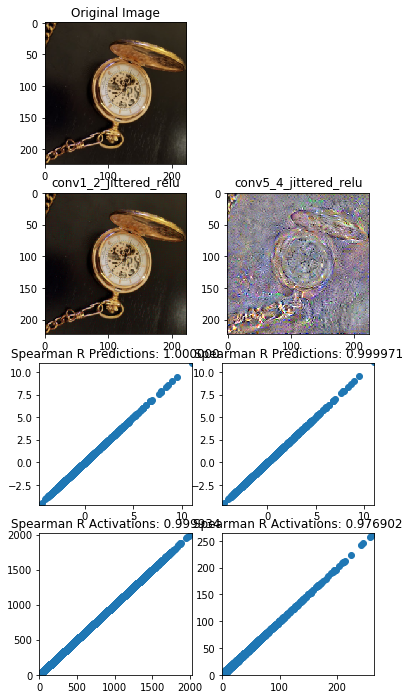

In [62]:
# Uncomment to synthesize and plot all of the metamer layers (WARNING: SLOW)
# plot_metamer_layers = metamer_layers

# Uncomment the below to only run one metamer layer
plot_metamer_layers = ['conv1_2_jittered_relu', 'conv5_4_jittered_relu']

# Metamers in Feather et al. 2019 ran for 15000 iterations of Adam as the loss began to flatten for many 
# model metamers at this point. The learning rate the iterations may need to be changed for some models. 
iterations_adam = 15000 
log_loss_every_num = 1000 # used to track the loss and intermediate examples
starting_learning_rate_adam = 0.001

num_layers = len(plot_metamer_layers)

plt.figure(figsize=(3*num_layers,12))

# Load the null distirbution to check the optimization.
null_distribution_file = 'vgg_null_dist_spearman_r.pckl'
null_distirbution_spearman_r = pickle.load(open('vgg_null_dist_spearman_r.pckl', 'rb'))

metamer_dict = {}

for layer_idx, layer in enumerate(plot_metamer_layers): 
    print('Generating metamer for VGG layer %s'%layer)
    
    # Reinitialize the input variable
    sess.run(input_noise_assign_op)
    
    # Get the loss on the layer features
    orig_features = sess.run(nets[layer], feed_dict = {input_tensor:[image_dict['image']]})
    losses = loss_function(nets[layer], orig_features, update_losses=[])
    
    # In case we had included multiple losses, sum over them
    loss = tf.reduce_sum(losses)

    # Build the optimizers and run the optimization
    total_loss, track_iters, track_images = metamer_helpers.run_optimization(
        loss, sess, input_tensor, iterations_adam, log_loss_every_num, 
        starting_learning_rate_adam=starting_learning_rate_adam)
    
    # Evaluate some of the tensors to save and to plot
    orig_predictions = sess.run(nets['logits'], feed_dict = {input_tensor:[image_dict['image']]})[0]
    synth_predictions = sess.run(nets['logits'])[0]
    synth_image = sess.run(input_tensor)
    synth_features = sess.run(nets[layer]).ravel()

    metamer_dict[layer] = {}
    metamer_dict[layer]['track_images'] = track_images
    metamer_dict[layer]['total_loss'] = total_loss
    metamer_dict[layer]['orig_features'] = orig_features
    metamer_dict[layer]['synth_features'] = synth_features
    metamer_dict[layer]['synth_image'] = synth_image
    metamer_dict[layer]['orig_image'] = [image_dict['image']]
    metamer_dict[layer]['orig_predictions'] = orig_predictions
    metamer_dict[layer]['synth_predictions'] = synth_predictions
    
    # Make some plots in the notebook 
    if layer_idx == 0:
        plt.subplot(4, num_layers, 1)
        plt.imshow(image_dict['image'])
        plt.title('Original Image')
    plt.subplot(4, num_layers, layer_idx+1+num_layers)
    plt.imshow(np.squeeze((synth_image)))
    plt.title('%s'%layer)
    ax=plt.subplot(4, num_layers, layer_idx+1+num_layers*2)
    plt.scatter(orig_predictions,synth_predictions)
    plt.ylim(ymin=np.min(orig_predictions),ymax=np.max(orig_predictions))
    plt.xlim(xmin=np.min(orig_predictions),xmax=np.max(orig_predictions))
    plt.title('Spearman R Predictions: %f'%(scipy.stats.spearmanr(orig_predictions,synth_predictions)[0]))

    ax=plt.subplot(4, num_layers, layer_idx+1+num_layers*3)
    plt.scatter(orig_features,synth_features)
    plt.ylim(ymin=np.min(orig_features.ravel()),ymax=np.max(orig_features.ravel()))
    plt.xlim(xmin=np.min(orig_features.ravel()),xmax=np.max(orig_features.ravel()))
    plt.title('Spearman R Activations: %f'%(scipy.stats.spearmanr(orig_features.ravel(),synth_features.ravel())[0]))

    print('Min orig: %f | Max orig : %f'%(np.min(image_dict['image'].ravel()), np.max(image_dict['image'].ravel())))
    print('Min synth: %f | Max synth : %f'%(np.min(synth_image.ravel()), np.max(synth_image.ravel())))


# For each layer, check that the optimized metamer meets the optimization criteria. 

(1) The network must predict the same thing for the synthetic and the original

(2) The Spearman R between the synthetic and the original must fall outside of the null distribution constructed on 1,000,000 images pairs (saved as `vgg_null_dist_spearman_r.pckl`). This is especially important for randomly initialized networks, where at the late layers the activations are all very correlated. 


In [64]:
null_distribution_file = 'vgg_null_dist_spearman_r.pckl'
null_distirbution_spearman_r = pickle.load(open('vgg_null_dist_spearman_r.pckl', 'rb'))

for layer_idx, layer in enumerate(plot_metamer_layers): 
    # Make sure that the Spearman R falls outside of the null distribution constructed from random image pairs
    spearman_r_metamer = scipy.stats.spearmanr(metamer_dict[layer]['orig_features'].ravel(), metamer_dict[layer]['synth_features'].ravel())[0]
    null_assertion = 'Synthesized metamer for layer %s falls within the null distribution of images. Optimization did not succeed.'%layer
    assert np.max(null_distirbution_spearman_r[layer]) < spearman_r_metamer, null_assertion

    # Make sure that the predicted class is the same for the original and the synthetic metamer
    class_assertion = 'Synthesized metamer for layer %s is not predicted as the same class as the original image. Optimization did not succeed.'%layer
    assert np.argmax(metamer_dict[layer]['orig_predictions']) == np.argmax(metamer_dict[layer]['synth_predictions']), class_assertion

print('Metamers for all layers passed the optimization criteria!')


Metamers for all layers passed the optimization criteria!
